# Fractional differentiate

This notebook will cover exercise answer.

* Exercise 5.1
* Exercise 5.2

As we go along, there will be some explanations.

Stationarity is a key concept in time-series, by now the idea itself has been demostrated in previous notebooks (Feat Importance).

Most of the functions below can be found under research/Features.

Contact: boyboi86@gmail.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

p = print

#pls take note of version
#numpy 1.17.3
#pandas 1.0.3
#sklearn 0.21.3

dollar = pd.read_csv('./research/Sample_data/dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

def getWeights(d, size):
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

def plotWeights(dRange, nPlots, size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_=getWeights(d, size = size)
        w_ = pd.DataFrame(w_, index = range(w_.shape[0])[:: -1], columns = [d])
        w=w.join(w_, how = "outer")
    ax = w.plot(figsize=(10,8))
    ax.legend(loc='upper left'); plt.show()
    return

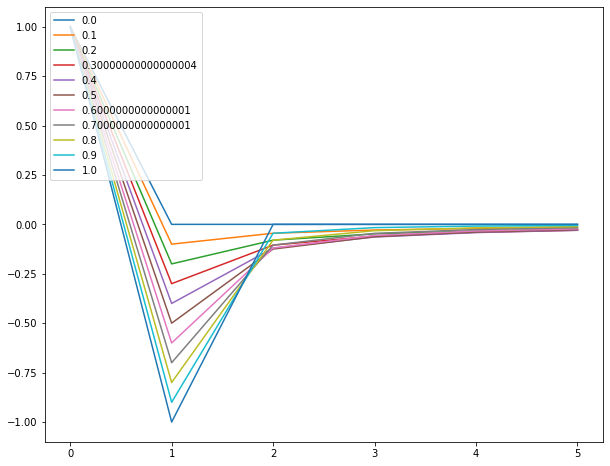

In [2]:
plotWeights(dRange = [0,1], nPlots = 11, size = 6)

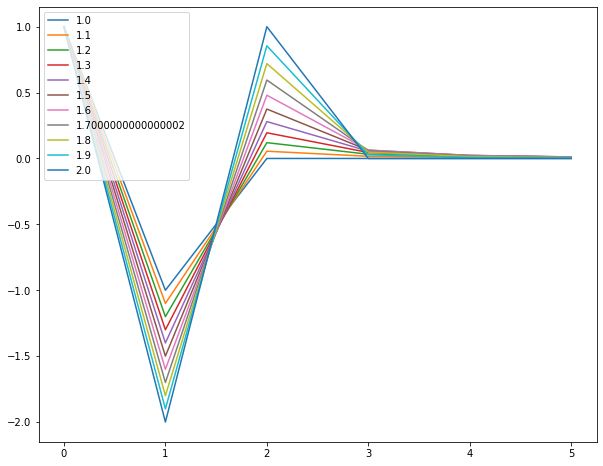

In [3]:
plotWeights(dRange = [1,2], nPlots = 11, size = 6)

In [4]:
def fracDiff(series, d, thres=.01):
    w=getWeights(d, series.shape[0])
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip = w_[w_>thres].shape[0]
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series(index=series.index, dtype=float)
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]): continue
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [5]:
close = dollar['close'].to_frame()
fd_0=fracDiff(series = close, d =.4, thres=.1) # first graph
fd_1=fracDiff(series = close, d =.4, thres=.01)# second graph

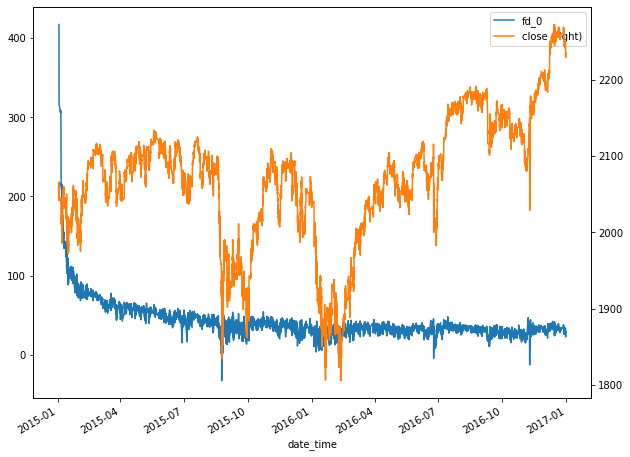

In [6]:
fd_0 = fd_0.rename(columns = {'close':'fd_0'})
fd_1 = fd_1.rename(columns = {'close':'fd_1'})

fd_0.dropna(inplace=True)
fd_1.dropna(inplace=True)

fdd = pd.DataFrame(index=close.index).assign(close = close, fd_0 = fd_0, fd_1 = fd_1)
fdd[['fd_0', 'close']].plot(secondary_y='close',figsize=(10,8))

#threshold set to 0.1

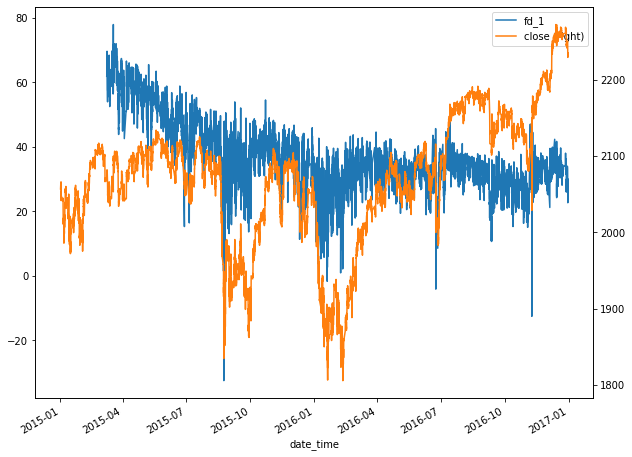

In [7]:
fdd[['fd_1', 'close']].plot(secondary_y='close',figsize=(10,8))

#threshold set to 0.01

In [8]:
def getWeights_FFD(d, thres):
    w,k=[1.],1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_) < thres:
            break
        w.append(w_); k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series, d, thres=1e-5):
    w, df = getWeights_FFD(d, thres), {}
    width = len(w)-1
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series(index=series.index, dtype=float)
        for iloc in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc - width], seriesF.index[iloc]
            if not np.isfinite(series.loc[loc1,name]): continue
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [9]:
ffd = fracDiff_FFD(close, d=0.4, thres=1e-5)
ffd = ffd.rename(columns = {'close':'ffd'})
ffd0 = pd.DataFrame(index=close.index).assign(close = close, ffd = ffd)

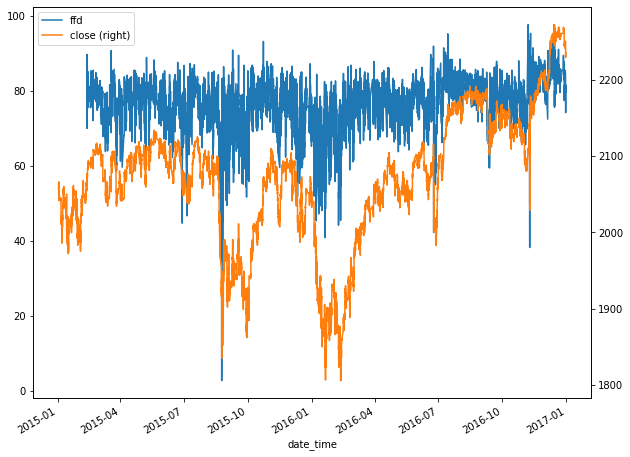

In [10]:
# Attain stationary TS using fixed window FFD
# Instead of allowing weight to decrease using expanding method
# We calculate weight and once threshold limit is reached, we start from there to calculate FFD

ffd0[['ffd', 'close']].plot(secondary_y='close',figsize=(10,8))

In [11]:
from scipy.stats import jarque_bera
from scipy.stats import linregress
from scipy.optimize import curve_fit 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
# Exercise 5.1

# generate 10000 IID random numbers 
nsample = 10000
mu = 0
sd = 1
ts = np.random.normal(mu, sd, nsample)

In [13]:
adf_test = adfuller(ts, autolag=None)
p("ADF pVal: {0}".format(adf_test[1])) #if less than 0.05 means stationary

ADF pVal: 1.3567325571929288e-28


In [14]:
cumsum_ts = ts.cumsum()
p("ADF pVal: {0}".format(adfuller(cumsum_ts, autolag=None)[1])) #if less than 0.05 means stationary

ADF pVal: 0.46730222931675713


In [15]:
cumsum_ts = np.diff(cumsum_ts)
p("ADF pVal: {0}".format(adfuller(cumsum_ts, autolag=None)[1])) #if less than 0.05 means stationary
p(cumsum_ts[0:6]) #first order

ADF pVal: 1.215748679254481e-28
[ 0.05655976  0.264295    0.13197913 -1.58697582  2.97293964  1.29691767]


In [16]:
cumsum_ts = np.diff(cumsum_ts)
p("ADF pVal: {0}".format(adfuller(cumsum_ts, autolag=None)[1])) #if less than 0.05 means stationary
p(cumsum_ts[0:6]) #second order

ADF pVal: 0.0
[ 0.20773524 -0.13231588 -1.71895495  4.55991546 -1.67602197 -1.22455731]


## Time-series differentiation outcome

The cumulative time-series is considered first order integration. 

Since stationarity can only be attain at that order, hence considered weak stationarity.

However, at first order integration p-value was 8.076983019330449e-29, which is lesser than 0.05.

When we repeated differentiate twice (Over-differentiate), it's p-value went down to zero, which is still lesser than 0.05.

If we just want to transform time-series stationary, all we required was to attain p-value less than 0.05. But a single order differentiation p-value was below 0.01, which points out to the excessive loss of memory

Hence, this demostrates the problem with over-differentiation and the "cost" of attaining stationarity at cost of memory.

> "We can always make a series more stationary through differentiation, but it will be at the cost of erasing memory, which will defeat the purpose of ML algorithm."
>
> Advances in Financial Machine Learning, page 76, section 5.2

ADF pVal: 0.9585096636544734


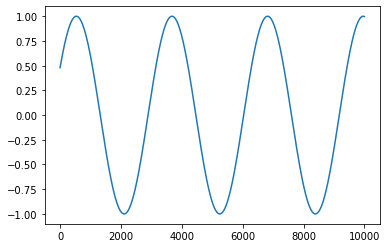

In [17]:
#Exercise 5.2

# generate 1000 points 
nsample = 10000
x=range(1,nsample+1)
## simulate a simple sinusoidal function
ns = np.linspace(0, 10, nsample)
y = pd.Series(1*np.sin(2.0 * ns + .5), dtype = float, index=x)
y.plot()
p("ADF pVal: {0}".format(adfuller(y, autolag=None)[1])) #if less than 0.05 means stationary

ADF pVal: 1.0


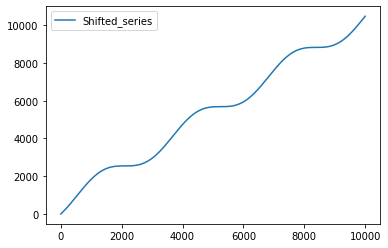

In [18]:
c_constant = 1.
y_shifted = (y + c_constant).cumsum().rename('Shifted_series').to_frame()
p("ADF pVal: {0}".format(adfuller(y_shifted.squeeze(), autolag=None)[1])) #if less than 0.05 means stationary
y_shifted.plot()

**Note**

We wanted to use sinusoidal function, because naturally stationary since they have an "anchor" around 0.

The idea of cumulative sum series is to create a "trend". This will create a non-stationary series. As reflected in p-value 1.0.

We know initially it was stationary, so we can apply certain methods to recover such stationarity. (Such methods may work on most time-series but not all, so do take note)

In [19]:
# this might take 2 mins
# pls note that not all log time-series data will improve convergence, kindly check with final result

def min_value(data: pd.Series, func, thres = 0.01, pval_threshold: float = 0.05):
    d_domain = np.linspace(start = 0, 
                           stop = 2, 
                           num=100, 
                           endpoint=True, 
                           retstep=False, 
                           dtype=float)
    
    for d in d_domain:
        #df1 = np.log(data).resample('1D').last()
        df1 = np.log(data)
        df1.dropna(inplace=True)
        df2 = func(data,d,thres = thres).dropna()
        df2 = adfuller(df2.squeeze(), maxlag=1, regression='c', autolag=None)
        try:
            if df2[1] <= pval_threshold:
                return round(d, 6)
        except:
            p('Something is wrong! Most likely required d value more than 2!!')

min_value(y_shifted, func = fracDiff)

0.020202

In [20]:
df = fracDiff(y_shifted, d =0.0202, thres=.01)
p("ADF pVal: {0}".format(adfuller(df['Shifted_series'].dropna(),
                                  maxlag=1,
                                  regression='c',
                                  autolag=None)[1])) #if less than 0.05 means stationary

ADF pVal: 8.918679926977976e-26


In [21]:
min_value(y_shifted, thres = 1e-5, func = fracDiff_FFD)

0.020202

In [22]:
df1 = fracDiff_FFD(y_shifted, d = 0.0202, thres=1e-5)
p("ADF pVal: {0}".format(adfuller(df1['Shifted_series'].dropna(), 
                                  maxlag=1, 
                                  regression='c', 
                                  autolag=None)[1])) #if less than 0.05 means stationary

ADF pVal: 1.6172026592903458e-16


## Conclusion

Both methods (Fixed Window & Expanding Window) requires the same minimal d value, which is 0.020202.

However, Fixed Window (FFD) method will allow greater p-value (1.6172026592903458e-16) hence attaining stationarity while preserving more memory.

#### Exercise 5.3

I decided to skip this part.

My guess is this, when you try to do a full differentiate at which d = 1. 

The sin function and sin "trend" series will recover with possible r-square = 0. or approximately close to 0.